# MSADS509 M3 UE Wang

# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need
from sklearn.feature_extraction.text import TfidfVectorizer 

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

import spacy

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords

import glob
!pip install --upgrade pip 
!pip install --upgrade Pillow
!pip install freetype-py
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

    #without adding extra stopwords: 
    #[('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333)]
    #[('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251)]
    
extra_sw = ['im', 'know', 'dont', 'youre', 'got', '', 'like']
sw.extend(extra_sw)

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))  
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(s) for s in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")        
        print (f"The five most common words are:")
        print(Counter(tokens).most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    
    #return(0)


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    
    return [t for t in tokens if t.lower() not in sw]

def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    
    return re.split(whitespace_pattern, text)
    #return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/UE/Desktop/M1 Results/" # change to your location if it is not in the same directory as your notebook

twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# read in the lyrics here

lyrics_data = {}

lyrics_path = os.path.join(data_location, lyrics_folder)

for artist_folder in os.listdir(lyrics_path):
    artist_folder_path = os.path.join(lyrics_path, artist_folder)

    if os.path.isdir(artist_folder_path):
        # Use glob to find all text files in the artist folder
        file_paths = glob.glob(os.path.join(artist_folder_path, '*.txt'))

        # Read the contents of each text file and store in artist_lyrics
        artist_lyrics = [open(file_path, 'r').read() for file_path in file_paths]

        lyrics_data[artist_folder] = artist_lyrics
        
print("Sample for robynkonichiwa:", lyrics_data['robyn'][:1])
print("--------------------------------------------")
print("Sample for cher:", lyrics_data['cher'][:1])

Sample for robynkonichiwa: ['"Include Me Out"\n\n\n\nIt is really very simple\nJust a single pulse, repeated at a regular interval\n\nMmm, hmm\nDon\'t include me out, no\nDon\'t include me out\n\nOne time for the records and the hits\nTwo for your money-maker, shake, boom\nThree times for the lucky and the dead\n\nOne time for the sorry and safe\nTwo for the beggar and his company\nThree times for the sinner and the saint\n\nYeah, bow down all you wicked and the vain\nBow to the miracle, the em, na, na\nThree times and the devil will be gone\n\nOne time for the fire, bring it on\nTwo for the boogie, gotta bang the beat\nThree times for the ladies, show me some love\n\nTalking \'bout everyone, every day, all day\n\nAnd if your world should fall apart\nThere\'s plenty room inside my heart\nJust don\'t include me out\nDon\'t include me out\n\nAnd if your world should fall apart\nI still got room inside my heart\nJust don\'t include me out\nDon\'t include me out, d-d-don\'t include me out\

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
robyn_lyrics = pd.DataFrame(lyrics_data['robyn'])
robyn_lyrics.columns = ['lyrics']
robyn_lyrics['artist'] = 'robyn'
robyn_lyrics = robyn_lyrics[['artist', 'lyrics']]

cher_lyrics = pd.DataFrame(lyrics_data['cher'])
cher_lyrics.columns = ['lyrics']
cher_lyrics['artist'] = 'cher'
cher_lyrics = cher_lyrics[['artist', 'lyrics']]

lyrics_data = pd.concat([robyn_lyrics, cher_lyrics], ignore_index=True)

# Display the merged DataFrame
display(lyrics_data.head())

,artist,lyrics
0,robyn,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,robyn,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,robyn,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,robyn,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,robyn,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."


In [9]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [10]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [11]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1000508,cher,"boy momma, childcare worker, always looking fo...","[boy, momma, childcare, worker, always, lookin..."
53512,robyn,"Animation graduate, artist, explorer, singer, ...","[animation, graduate, artist, explorer, singer..."
37560,cher,"||Taliban|∆|™ •10, 000 volts and now he's gone...","[taliban∆™, •10, 000, volts, hes, gone, hes, h..."
1245482,cher,Probably somewhere bein fass ♍️ 👆🏾 ♊️ ☀️ ♓️ 🌙 🌈,"[probably, somewhere, bein, fass, ♍️, 👆🏾, ♊️, ..."
1455948,cher,16 years young. 🌺 Kansas 🌻,"[16, years, young, 🌺, kansas, 🌻]"
2549884,cher,The body achieves what The mind Believes!! ❤❤ ❤,"[body, achieves, mind, believes, ❤❤, ❤]"
57228,robyn,Marketer making Media & #DigitalSense of the w...,"[marketer, making, media, #digitalsense, world..."
1026319,cher,Native New Yorker. east villager.Exec Assist @...,"[native, new, yorker, east, villagerexec, assi..."
34067,robyn,Dancing in a place between the Moon 🌒 and the ...,"[dancing, place, moon, 🌒, stars, ✨, ponder, im..."
592664,cher,Makeup + skincare aficionado. Dog lover 🐾 Avid...,"[makeup, skincare, aficionado, dog, lover, 🐾, ..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: 
One potential area for improvement in our tokenization process involves addressing situations where the original text lacks whitespaces between emojis and text. Currently, our tokenization treats them as a single token. To enhance this, we could consider separating emojis as individual tokens even when they are not surrounded by whitespaces. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [12]:
cher_tokens = lyrics_data[lyrics_data['artist'] == 'cher']['tokens'].sum()
robyn_tokens = lyrics_data[lyrics_data['artist'] == 'robyn']['tokens'].sum()

cher_stats = descriptive_stats(cher_tokens)

print("\nCher's Descriptive Stats:", cher_stats)

print("\n")

robyn_stats = descriptive_stats(robyn_tokens)

print("\nRobyn's Descriptive Stats:", robyn_stats)

There are 33629 tokens in the data.
There are 3697 unique tokens in the data.
There are 164423 characters in the data.
The lexical diversity is 0.110 in the data.
The five most common words are:
[('love', 1004), ('time', 319), ('baby', 319), ('see', 308), ('oh', 306)]

Cher's Descriptive Stats: [33629, 3697, 0.10993487763537423, 164423]


There are 13667 tokens in the data.
There are 2150 unique tokens in the data.
There are 68227 characters in the data.
The lexical diversity is 0.157 in the data.
The five most common words are:
[('love', 275), ('baby', 222), ('never', 155), ('dance', 150), ('beat', 146)]

Robyn's Descriptive Stats: [13667, 2150, 0.1573132362625302, 68227]


Q: what observations do you make about these data? 

A: 
Cher has more songs and longer lyrics, but her lyrics exhibit lower lexical diversity compared to Robyn's. Both artists frequently use the words 'love' and 'baby,' which are common themes in many songs. However, Robyn's lyrics stand out with the inclusion of 'dance' and 'beat' among their top five most common words. On the other hand, Cher's lyrics feature 'time' in the top five, a word not present in Robyn's most common words. This distinction suggests differences in their lyrical preferences and themes.

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [13]:
# Lyrics:

# your code here

# Count the tokens
robyn_tokens_counter = Counter(robyn_tokens)
robyn_tokens_counter = pd.DataFrame.from_dict(robyn_tokens_counter, orient='index', 
                                              columns=['robyn_Count']).reset_index()
robyn_tokens_counter = robyn_tokens_counter.rename(columns={'index': 'Token'})
robyn_tokens_counter['robyn_Concentration'] = (robyn_tokens_counter['robyn_Count'] / 
                                               sum(robyn_tokens_counter['robyn_Count'])) * 100

cher_tokens_counter = Counter(cher_tokens)
cher_tokens_counter = pd.DataFrame.from_dict(cher_tokens_counter, orient='index', 
                                             columns=['cher_Count']).reset_index()
cher_tokens_counter = cher_tokens_counter.rename(columns={'index': 'Token'})
cher_tokens_counter['cher_Concentration'] = (cher_tokens_counter['cher_Count'] / 
                                             sum(cher_tokens_counter['cher_Count'])) * 100


merged_lyric_count = pd.merge(robyn_tokens_counter, cher_tokens_counter, on='Token', how='inner')

# Filter based on count > 5 in both columns
filtered_lyric_count = merged_lyric_count[(merged_lyric_count['robyn_Count'] > 5) & 
                                          (merged_lyric_count['cher_Count'] > 5)]
filtered_lyric_count

,Token,robyn_Count,robyn_Concentration,cher_Count,cher_Concentration
0,really,54,0.395112,94,0.279521
3,one,63,0.460964,282,0.838562
4,time,105,0.768274,319,0.948586
6,two,17,0.124387,42,0.124892
7,shake,18,0.131704,6,0.017842
...,...,...,...,...,...
1039,88,14,0.102437,6,0.017842
1040,days,15,0.109753,38,0.112998
1061,part,8,0.058535,13,0.038657
1112,uh,6,0.043901,6,0.017842


In [14]:
filtered_lyric_count['robyn/cher_Ratio'] = (
    filtered_lyric_count['robyn_Concentration'] /
    filtered_lyric_count['cher_Concentration']
)

filtered_lyric_count['cher/robyn_Ratio'] = (
    filtered_lyric_count['cher_Concentration'] /
    filtered_lyric_count['robyn_Concentration']
)

In [15]:
filtered_lyric_count.sort_values('robyn/cher_Ratio',ascending = False).head(10)

,Token,robyn_Count,robyn_Concentration,cher_Count,cher_Concentration,robyn/cher_Ratio,cher/robyn_Ratio
30,beat,146,1.068267,17,0.050552,21.132199,0.047321
220,dance,150,1.097534,25,0.074341,14.763591,0.067734
228,work,76,0.556084,15,0.044604,12.467033,0.080212
603,hang,38,0.278042,8,0.023789,11.687843,0.085559
7,shake,18,0.131704,6,0.017842,7.381796,0.135468
110,alright,30,0.219507,10,0.029736,7.381796,0.135468
122,party,21,0.153655,8,0.023789,6.459071,0.154821
319,space,20,0.146338,8,0.023789,6.151496,0.162562
330,pretend,15,0.109753,6,0.017842,6.151496,0.162562
125,lets,47,0.343894,20,0.059472,5.782407,0.172938


In [16]:
filtered_lyric_count.sort_values('cher/robyn_Ratio',ascending = False).head(10)

,Token,robyn_Count,robyn_Concentration,cher_Count,cher_Concentration,robyn/cher_Ratio,cher/robyn_Ratio
535,find,6,0.043901,137,0.407386,0.107763,9.279585
350,enough,7,0.051218,129,0.383597,0.133521,7.489467
300,man,12,0.087803,213,0.633382,0.138625,7.213692
147,believe,11,0.080486,145,0.431175,0.186666,5.357159
69,well,16,0.117070,164,0.487674,0.240058,4.165653
713,home,11,0.080486,105,0.312231,0.257777,3.879322
214,hope,6,0.043901,57,0.169497,0.259010,3.860849
894,till,6,0.043901,55,0.163549,0.268429,3.725381
538,many,6,0.043901,52,0.154628,0.283915,3.522178
832,sleep,7,0.051218,59,0.175444,0.291935,3.425415


In [17]:
# Twitter:

cher_twitter_tokens = twitter_data[twitter_data['artist'] == 'cher']['tokens'].explode().tolist()
robyn_twitter_tokens = twitter_data[twitter_data['artist'] == 'robyn']['tokens'].explode().tolist()

# Count the tokens
robyn_twitter_tokens_counter = Counter(robyn_twitter_tokens)
robyn_twitter_tokens_counter = pd.DataFrame.from_dict(robyn_twitter_tokens_counter, orient='index', 
                                                      columns=['robyn_Count']).reset_index()
robyn_twitter_tokens_counter = robyn_twitter_tokens_counter.rename(columns={'index': 'Token'})
robyn_twitter_tokens_counter['robyn_Concentration'] = (robyn_twitter_tokens_counter['robyn_Count'] / 
                                                       sum(robyn_twitter_tokens_counter['robyn_Count'])) * 100

cher_twitter_tokens_counter = Counter(cher_twitter_tokens)
cher_twitter_tokens_counter = pd.DataFrame.from_dict(cher_twitter_tokens_counter, orient='index', 
                                                     columns=['cher_Count']).reset_index()
cher_twitter_tokens_counter = cher_twitter_tokens_counter.rename(columns={'index': 'Token'})
cher_twitter_tokens_counter['cher_Concentration'] = (cher_twitter_tokens_counter['cher_Count'] / 
                                                     sum(cher_twitter_tokens_counter['cher_Count'])) * 100


merged_twitter_count = pd.merge(robyn_twitter_tokens_counter, cher_twitter_tokens_counter, on='Token', how='inner')

# Filter based on count > 5 in both columns
filtered_twitter_count = merged_twitter_count[(merged_twitter_count['robyn_Count'] > 5) & 
                                              (merged_twitter_count['cher_Count'] > 5)]
filtered_twitter_count


,Token,robyn_Count,robyn_Concentration,cher_Count,cher_Concentration
0,love,11615,0.705896,213522,1.226807
1,chill,120,0.007293,1559,0.008957
3,instagram,2444,0.148533,20312,0.116704
4,soundcloud,151,0.009177,422,0.002425
5,books,936,0.056885,11742,0.067465
...,...,...,...,...,...
121965,⊙,7,0.000425,50,0.000287
123008,◊,6,0.000365,15,0.000086
126762,politiek,6,0.000365,44,0.000253
127967,ô,6,0.000365,18,0.000103


In [18]:
filtered_twitter_count['robyn/cher_Ratio'] = (
    filtered_twitter_count['robyn_Concentration'] /
    filtered_twitter_count['cher_Concentration']
)

filtered_twitter_count['cher/robyn_Ratio'] = (
    filtered_twitter_count['cher_Concentration'] /
    filtered_twitter_count['robyn_Concentration']
)

In [19]:
filtered_twitter_count.sort_values('robyn/cher_Ratio',ascending = False).head(10)

,Token,robyn_Count,robyn_Concentration,cher_Count,cher_Concentration,robyn/cher_Ratio,cher/robyn_Ratio
4485,sveriges,294,0.017868,15,0.000086,207.321460,0.004823
23176,träning,115,0.006989,6,0.000034,202.737822,0.004932
15115,brinner,131,0.007961,7,0.000040,197.952706,0.005052
21376,följ,221,0.013431,12,0.000069,194.804603,0.005133
4405,gärna,202,0.012276,11,0.000063,194.243668,0.005148
7354,arbetar,194,0.011790,11,0.000063,186.550850,0.005360
11644,varje,104,0.006321,6,0.000034,183.345508,0.005454
6672,familj,102,0.006199,6,0.000034,179.819633,0.005561
31347,projektledare,115,0.006989,7,0.000040,173.775276,0.005755
7337,detta,109,0.006624,7,0.000040,164.708740,0.006071


In [20]:
filtered_twitter_count.sort_values('cher/robyn_Ratio',ascending = False).head(10)

,Token,robyn_Count,robyn_Concentration,cher_Count,cher_Concentration,robyn/cher_Ratio,cher/robyn_Ratio
5343,grandmother,19,0.001155,7132,0.040977,0.028179,35.487021
11783,#fbr,12,0.000729,3131,0.017989,0.040540,24.666847
1655,resister,7,0.000425,1817,0.010440,0.040750,24.539669
28954,nana,8,0.000486,2010,0.011549,0.042100,23.752968
3078,rbsoul,7,0.000425,1530,0.008791,0.048394,20.663563
14152,grandma,27,0.001641,5705,0.032779,0.050061,19.975778
24060,#theresistance,16,0.000972,3211,0.018449,0.052707,18.972831
40971,hiphoprap,13,0.000790,2479,0.014243,0.055470,18.027894
6031,gop,7,0.000425,1288,0.007400,0.057487,17.395208
5163,grandchildren,13,0.000790,2306,0.013249,0.059631,16.769795


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: 
robyn's lyrics top ten concentrated ratio tokens compare to cher is:
"beat," "dance," "work" , "hang", "shake", "alright", "party", "space", "pretend", "lets". 
That tells robyn songs are more focus on energetic and lively elements. These findings suggest that Robyn's songs are oriented towards the vibrant atmosphere of parties and social gatherings..


cher's lyrics top ten concentrated ratio tokens compare to robyn is:
"find" "enough," "man" , "believe", "well", "home", , "hope", "till", "many", "sleep". 
This tells us cher's songs are more emphasis on introspection, relationships, and personal sentiments. Notably, words such as "home," "hope," and "sleep" further suggest a more relaxed and contemplative tone in Cher's songs.

robyn's twitter top ten concentrated ratio tokens compare to cher is:
"sveriges", "träning", "brinner", "följ", "gärna", "arbetar", "varje", "familj", "projektledare", "detta".
These words translate to Sweden's, training, burns, follow, gladly, work, every, family, project manager, and this, respectively. The prevalence of terms related to work and life suggests that Robyn's related Twitter content may have a focus on professional and personal aspects, possibly indicating a strong presence of Swedish followers among her audience.

cher's twitter top ten concentrated ratio tokens compare to robyn is:
"grandmother", "#fbr", "resister", "nana", "rbsoul", "grandma", "#theresistance", "hiphoprap", "gop", "grandchildren".
These words, centered around family-related and political themes, suggest that Cher's related Twitter content appeals to a demographic that values family connections, activism, and engagement with political discourse.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [21]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

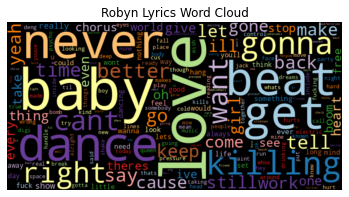

In [22]:
robyn_lyrics_tokens_wc = lyrics_data[lyrics_data['artist'] == 'robyn']['tokens']
robyn_lyrics_tokens_wc = pd.DataFrame(robyn_lyrics_tokens_wc)
robyn_lyrics_word_freq = count_words(robyn_lyrics_tokens_wc)
robyn_lyrics_word_freq = robyn_lyrics_word_freq.squeeze()
wordcloud(robyn_lyrics_word_freq, "Robyn Lyrics Word Cloud")

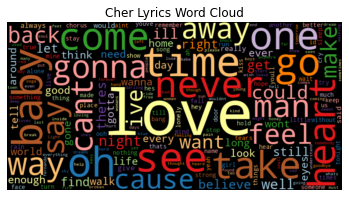

In [23]:
cher_lyrics_tokens_wc = lyrics_data[lyrics_data['artist'] == 'cher']['tokens']
cher_lyrics_tokens_wc = pd.DataFrame(cher_lyrics_tokens_wc)
cher_lyrics_word_freq = count_words(cher_lyrics_tokens_wc)
cher_lyrics_word_freq = cher_lyrics_word_freq.squeeze()
wordcloud(cher_lyrics_word_freq, "Cher Lyrics Word Cloud")

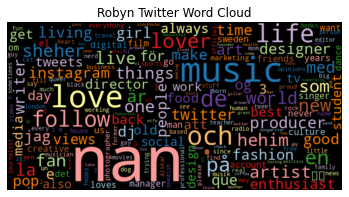

In [24]:
robyn_twitter_tokens_wc = twitter_data[twitter_data['artist'] == 'robyn']['tokens']
robyn_twitter_tokens_wc = pd.DataFrame(robyn_twitter_tokens_wc)
robyn_twitter_word_freq = count_words(robyn_twitter_tokens_wc)
robyn_twitter_word_freq = robyn_twitter_word_freq.squeeze()
wordcloud(robyn_twitter_word_freq, "Robyn Twitter Word Cloud")

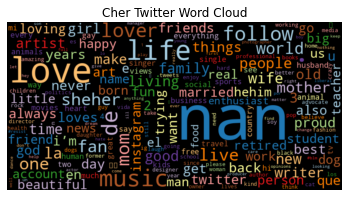

In [25]:
cher_twitter_tokens_wc = twitter_data[twitter_data['artist'] == 'cher']['tokens']
cher_twitter_tokens_wc = pd.DataFrame(cher_twitter_tokens_wc)
cher_twitter_word_freq = count_words(cher_twitter_tokens_wc)
cher_twitter_word_freq = cher_twitter_word_freq.squeeze()
wordcloud(cher_twitter_word_freq, "Cher Twitter Word Cloud")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: 
Cher and Robyn's lyrics share many common words, including "love," "baby," "never," and "cause." However, one notable distinction is that Robyn includes the word "killing," which sets her lyrics apart from Cher's. The presence of this unique term is easily noticeable.

In their Twitter word clouds, there is a substantial overlap in terms like 'love,' 'nan,' 'life,' and 'follow.' Additionally, Robyn's Twitter includes words related profession that are less prevalent in Cher's, such as 'designer,' 'artist,' 'producer,' and 'writer.' On the other hand, Cher's Twitter tokens emphasize more positive aspects, with words like 'music,' 'happy,' 'beautiful,' and 'family' indicating a theme of optimism and appreciation for familial connections.